# 1 - Querying top miner UID

In [ ]:
import bittensor as bt

USE_TESTNET = False

if USE_TESTNET:
    metagraph = bt.metagraph(netuid=118, network="test")
else:
    metagraph = bt.metagraph(netuid=2, network="finney")

top_miner_uid = int(metagraph.incentive.argmax())
print(top_miner_uid)

# 2 - Demonstration of Rewards

## Proof of Weights

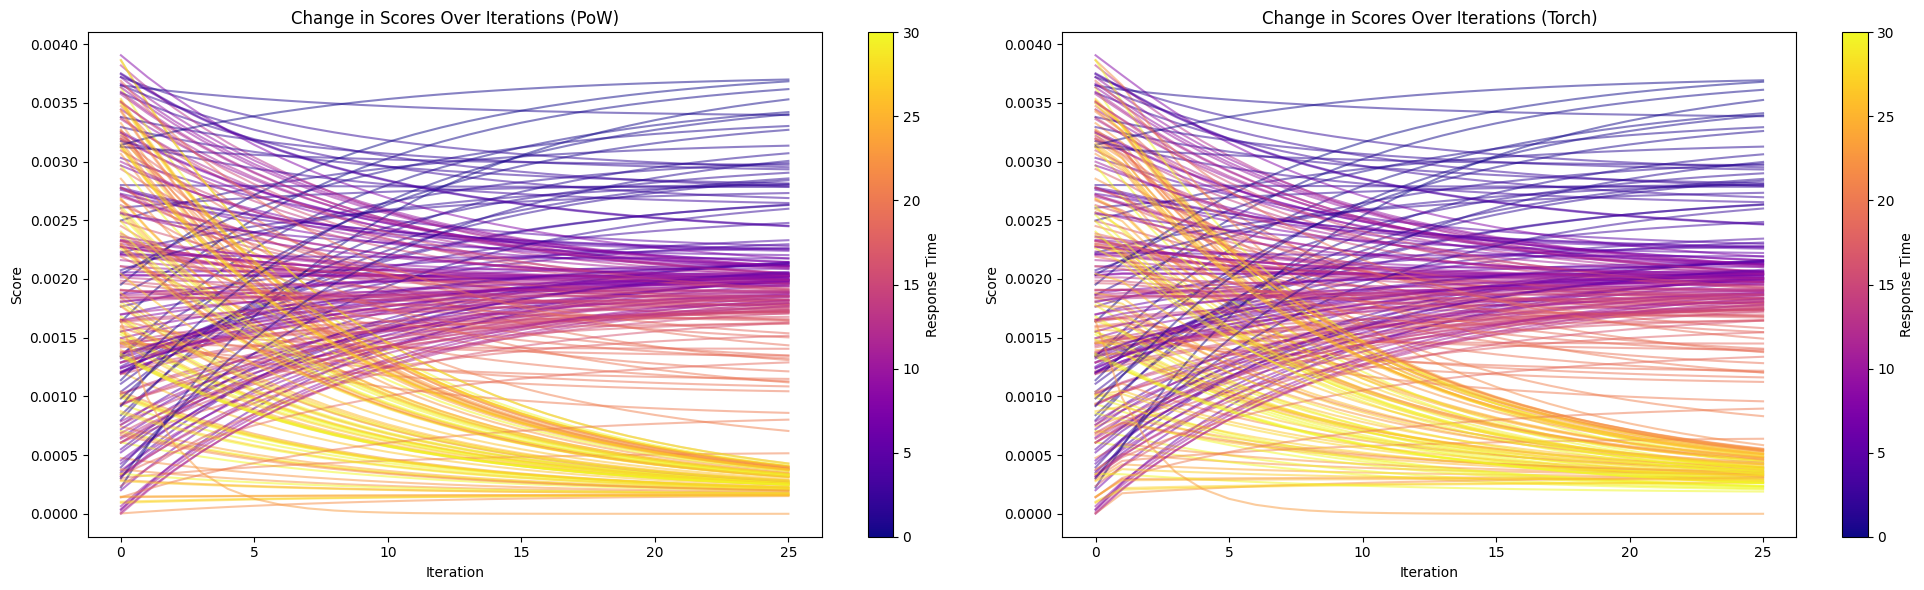

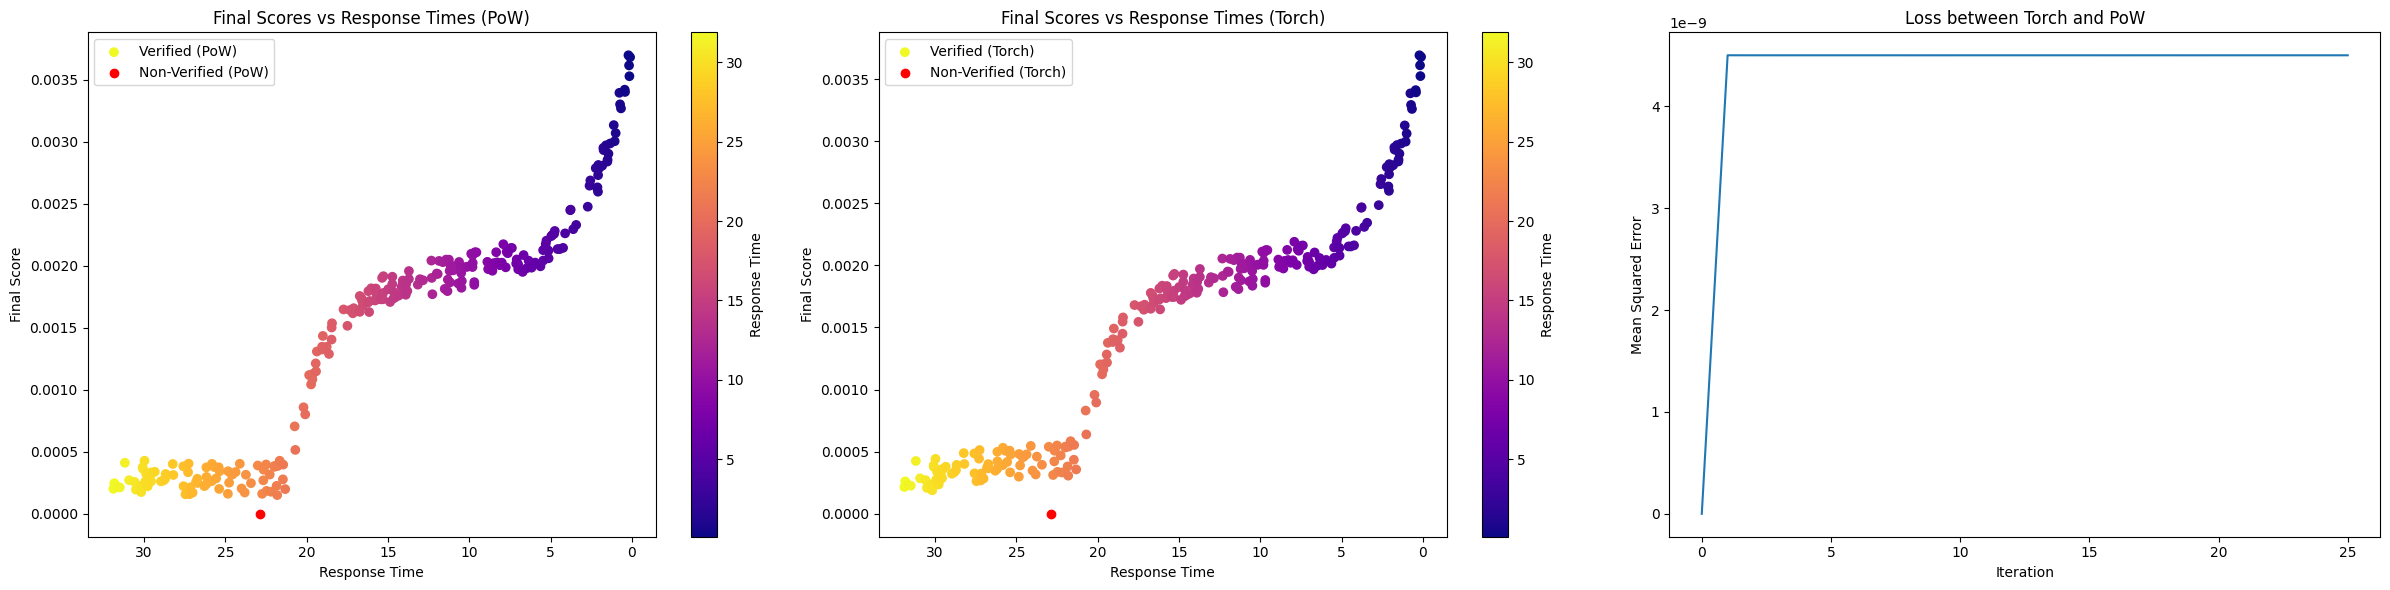

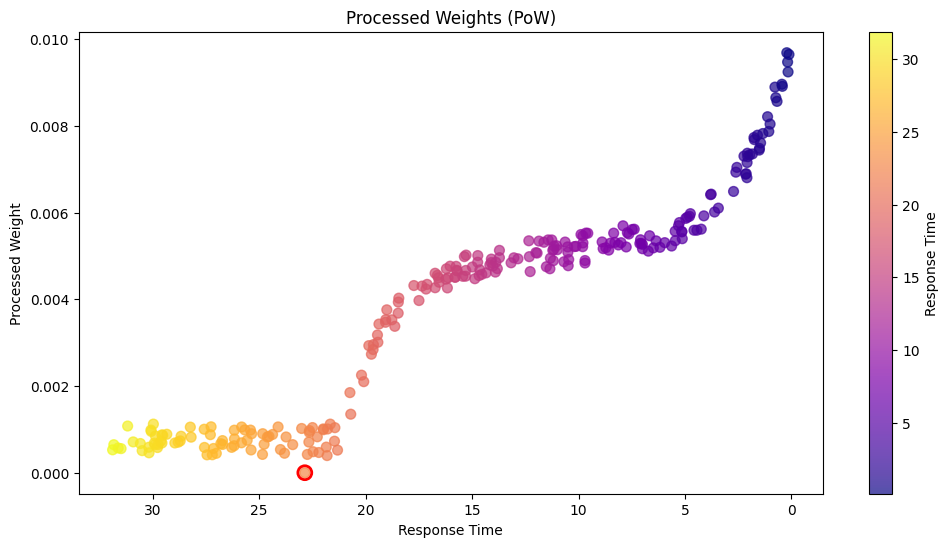

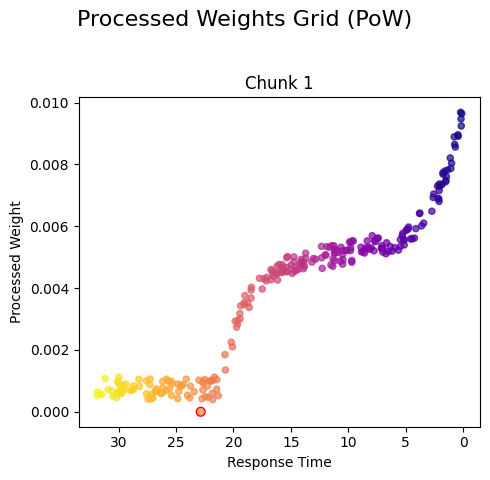

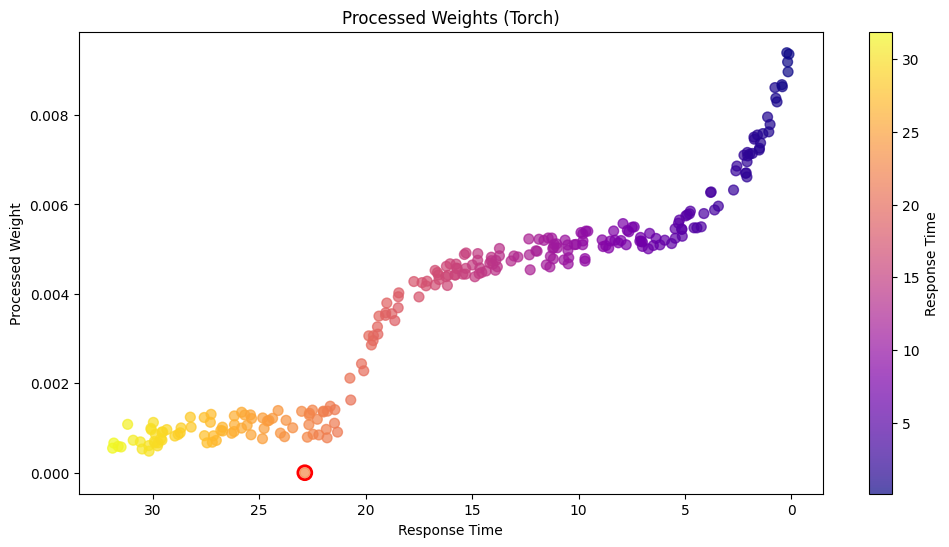

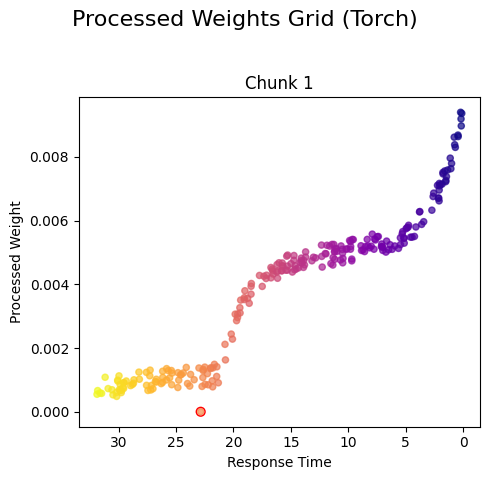

In [2]:
import torch
import random
import logging
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple
import bittensor as bt
import numpy as np
from _validator.scoring.reward import FLATTENING_COEFFICIENT, MAXIMUM_RESPONSE_TIME_DECIMAL, PROOF_SIZE_THRESHOLD, PROOF_SIZE_WEIGHT, RATE_OF_DECAY, RATE_OF_RECOVERY, RESPONSE_TIME_WEIGHT, Reward
from deployment_layer.circuit_store import circuit_store

from constants import BATCHED_PROOF_OF_WEIGHTS_MODEL_ID, SINGLE_PROOF_OF_WEIGHTS_MODEL_ID
from execution_layer.verified_model_session import VerifiedModelSession

MAX_RESPONSE_TIME = 30
MIN_RESPONSE_TIME = 0
NUM_KEYS_TO_SIMULATE = 256
PLOT_INTERVALS = 25
MAX_SCORE = 1 / 256
BATCH_SIZE = 256
ENABLE_LOGS = False
FIX_TIMES_AFTER_INTERVAL = False

MODEL_ID = SINGLE_PROOF_OF_WEIGHTS_MODEL_ID if BATCH_SIZE == 256 else BATCHED_PROOF_OF_WEIGHTS_MODEL_ID

circuit = circuit_store.get_circuit(MODEL_ID)

if ENABLE_LOGS:
    bt.logging.on()
else:
    bt.logging.off()
    logging.disable(logging.CRITICAL)

def log(message: str) -> None:
    if ENABLE_LOGS:
        print(message)


def run_inference_via_proof_system(
    batch_inputs: Dict[str, torch.Tensor]
) -> torch.Tensor:
    if not circuit:
        raise ValueError("Circuit is not available.")
    if not circuit.settings:
        raise ValueError("Circuit settings are not available.")
    scale = circuit.settings["scaling"]

    modified_inputs = {
        "RATE_OF_DECAY": int(RATE_OF_DECAY * scale),
        "RATE_OF_RECOVERY": int(RATE_OF_RECOVERY * scale),
        "FLATTENING_COEFFICIENT": int(FLATTENING_COEFFICIENT * scale),
        "PROOF_SIZE_WEIGHT": int(PROOF_SIZE_WEIGHT * scale),
        "PROOF_SIZE_THRESHOLD": int(PROOF_SIZE_THRESHOLD * scale),
        "RESPONSE_TIME_WEIGHT": int(RESPONSE_TIME_WEIGHT * scale),
        "MAXIMUM_RESPONSE_TIME_DECIMAL": int(MAXIMUM_RESPONSE_TIME_DECIMAL * scale),
        "maximum_score": (batch_inputs["maximum_score"] * scale).int().tolist(),
        "previous_score": (batch_inputs["previous_score"] * scale).int().tolist(),
        "verified": batch_inputs["verified"].tolist(),
        "proof_size": (batch_inputs["proof_size"] * scale).int().tolist(),
        "response_time": (batch_inputs["response_time"] * scale).int().tolist(),
        "maximum_response_time": (batch_inputs["maximum_response_time"] * scale).int().tolist(),
        "minimum_response_time": (batch_inputs["minimum_response_time"] * scale).int().tolist(),
        "block_number": batch_inputs["block_number"].tolist(),
        "validator_uid": batch_inputs["validator_uid"].tolist(),
        "miner_uid": batch_inputs["miner_uid"].tolist(),
        "scaling": scale,
    }


    session = VerifiedModelSession(modified_inputs, circuit)
    witness_content = session.generate_witness(return_content=True)
    scores = torch.tensor([float(x) for x in (witness_content[1:BATCH_SIZE + 1])])

    return scores / scale

def generate_sample_inputs() -> Dict[str, torch.Tensor]:
    inputs = {
        "maximum_score": torch.full((BATCH_SIZE,), MAX_SCORE, dtype=torch.float32),
        "previous_score": torch.tensor(
            [random.uniform(0, MAX_SCORE) for _ in range(BATCH_SIZE)],
            dtype=torch.float32,
        ),
        "verified": torch.tensor(
            [i != BATCH_SIZE - 1 for i in range(BATCH_SIZE)], dtype=torch.bool
        ),
        "proof_size": torch.tensor(
            [random.randint(0, 10000) for _ in range(BATCH_SIZE)], dtype=torch.int32
        ),
        "response_time": torch.tensor(
            [
                random.uniform(MIN_RESPONSE_TIME, MAX_RESPONSE_TIME + 2)
                for _ in range(BATCH_SIZE)
            ],
            dtype=torch.float32,
        ),
        "maximum_response_time": torch.full(
            (BATCH_SIZE,), MAX_RESPONSE_TIME, dtype=torch.float32
        ),
        "minimum_response_time": torch.full(
            (BATCH_SIZE,), MIN_RESPONSE_TIME, dtype=torch.float32
        ),
        "block_number": torch.tensor(
            [random.randint(3000000, 10000000) for _ in range(BATCH_SIZE)],
            dtype=torch.int32,
        ),
        "validator_uid": torch.tensor(
            [random.randint(0, 256) for _ in range(BATCH_SIZE)], dtype=torch.int32
        ),
        "miner_uid": torch.tensor(
            [random.randint(0, 256) for _ in range(BATCH_SIZE)], dtype=torch.int32
        ),
    }
    log(
        f"Generated sample inputs. Shape of 'maximum_score': {inputs['maximum_score'].shape}"
    )
    return inputs


def run_iterations(
    num_iterations: int, initial_inputs: Dict[str, torch.Tensor]
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    sample_inputs = initial_inputs.copy()
    original_response_times = sample_inputs["response_time"].clone()
    original_verified = sample_inputs["verified"].clone()

    scores_pow = [sample_inputs["previous_score"].clone()]
    scores_torch = [sample_inputs["previous_score"].clone()]
    reward_model = Reward()

    for i in range(num_iterations):
        log(f"Running iteration {i+1}/{num_iterations}")
        if FIX_TIMES_AFTER_INTERVAL:
            if i == num_iterations // 3:
                sample_inputs["response_time"] = torch.full(
                    (BATCH_SIZE,), 4.0, dtype=torch.float32
                )
            elif i == 2 * num_iterations // 3:
                sample_inputs["response_time"] = torch.full(
                    (BATCH_SIZE,), 10.0, dtype=torch.float32
                )

        new_scores_pow = run_inference_via_proof_system(sample_inputs)
        new_scores_torch = reward_model(**sample_inputs)[0]

        scores_pow.append(new_scores_pow)
        scores_torch.append(new_scores_torch)

        sample_inputs["previous_score"] = new_scores_pow.clone()
        log(
            f"Updated previous_score for next iteration: {sample_inputs['previous_score'][:5]}..."
        )

    log(
        f"Completed {num_iterations} iterations. Final scores shape: {scores_pow[-1].shape}"
    )
    return (
        torch.stack(scores_pow),
        torch.stack(scores_torch),
        original_response_times,
        original_verified,
    )


def plot_scores_over_time(
    scores_over_time_pow: torch.Tensor,
    scores_over_time_torch: torch.Tensor,
    response_times: torch.Tensor,
) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    norm = plt.Normalize(vmin=MIN_RESPONSE_TIME, vmax=MAX_RESPONSE_TIME)
    cmap = plt.get_cmap("plasma")

    for i in range(BATCH_SIZE):
        color = cmap(norm(response_times[i].item()))
        ax1.plot(
            range(PLOT_INTERVALS + 1),
            scores_over_time_pow[:, i],
            color=color,
            alpha=0.5,
        )
    sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm1.set_array([])
    fig.colorbar(sm1, ax=ax1, label="Response Time")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Score")
    ax1.set_title("Change in Scores Over Iterations (PoW)")

    for i in range(BATCH_SIZE):
        color = cmap(norm(response_times[i].item()))
        ax2.plot(
            range(PLOT_INTERVALS + 1),
            scores_over_time_torch[:, i],
            color=color,
            alpha=0.5,
        )
    sm2 = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm2.set_array([])
    fig.colorbar(sm2, ax=ax2, label="Response Time")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Score")
    ax2.set_title("Change in Scores Over Iterations (Torch)")

    plt.tight_layout()
    plt.show()


def plot_scores_vs_response_times_with_loss(
    final_scores_pow: torch.Tensor,
    final_scores_torch: torch.Tensor,
    response_times: torch.Tensor,
    verified: torch.Tensor,
    loss: torch.Tensor,
) -> None:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

    sorted_indices = torch.argsort(response_times, descending=True)
    sorted_response_times = response_times[sorted_indices]
    sorted_scores_pow = final_scores_pow[sorted_indices]
    sorted_scores_torch = final_scores_torch[sorted_indices]
    sorted_verified = verified[sorted_indices]

    scatter_pow = ax1.scatter(
        sorted_response_times[sorted_verified],
        sorted_scores_pow[sorted_verified],
        c=sorted_response_times[sorted_verified],
        cmap="plasma",
        label="Verified (PoW)",
    )
    ax1.scatter(
        sorted_response_times[~sorted_verified],
        sorted_scores_pow[~sorted_verified],
        c="red",
        label="Non-Verified (PoW)",
    )
    fig.colorbar(scatter_pow, ax=ax1, label="Response Time")
    ax1.set_xlabel("Response Time")
    ax1.set_ylabel("Final Score")
    ax1.set_title("Final Scores vs Response Times (PoW)")
    ax1.legend()
    ax1.invert_xaxis()

    scatter_torch = ax2.scatter(
        sorted_response_times[sorted_verified],
        sorted_scores_torch[sorted_verified],
        c=sorted_response_times[sorted_verified],
        cmap="plasma",
        label="Verified (Torch)",
    )
    ax2.scatter(
        sorted_response_times[~sorted_verified],
        sorted_scores_torch[~sorted_verified],
        c="red",
        label="Non-Verified (Torch)",
    )
    fig.colorbar(scatter_torch, ax=ax2, label="Response Time")
    ax2.set_xlabel("Response Time")
    ax2.set_ylabel("Final Score")
    ax2.set_title("Final Scores vs Response Times (Torch)")
    ax2.legend()
    ax2.invert_xaxis()

    ax3.plot(range(len(loss)), loss.numpy())
    ax3.set_xlabel("Iteration")
    ax3.set_ylabel("Mean Squared Error")
    ax3.set_title("Loss between Torch and PoW")

    plt.tight_layout()
    plt.show()

    log(f"PoW - Sorted final scores sample: {sorted_scores_pow[:5]}...")
    log(f"PoW - Sorted response times sample: {sorted_response_times[:5]}...")
    log(f"PoW - Sorted verified status sample: {sorted_verified[:5]}...")
    log(f"Torch - Sorted final scores sample: {sorted_scores_torch[:5]}...")
    log(f"Torch - Sorted response times sample: {sorted_response_times[:5]}...")
    log(f"Torch - Sorted verified status sample: {sorted_verified[:5]}...")


def process_weights(
    scores: torch.Tensor, uids: torch.Tensor, netuid: int, subtensor: bt.subtensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    return bt.utils.weight_utils.process_weights_for_netuid(
        uids=uids, weights=scores, netuid=netuid, subtensor=subtensor
    )


def plot_processed_weights(
    processed_uids: torch.Tensor,
    processed_weights: torch.Tensor,
    response_times: torch.Tensor,
    verified: torch.Tensor,
    title: str,
) -> None:
    sorted_indices = torch.argsort(response_times, descending=True)
    sorted_uids = processed_uids[sorted_indices]
    sorted_weights = processed_weights[sorted_indices]
    sorted_response_times = response_times[sorted_indices]
    sorted_verified = verified[sorted_indices]

    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(
        sorted_response_times.numpy(),
        sorted_weights.numpy(),
        c=sorted_response_times.numpy(),
        cmap="plasma",
        s=50,
        alpha=0.7,
    )

    plt.scatter(
        sorted_response_times[~sorted_verified].numpy(),
        sorted_weights[~sorted_verified].numpy(),
        facecolors="none",
        edgecolors="red",
        s=100,
        linewidths=2,
    )

    plt.colorbar(scatter, label="Response Time")
    plt.xlabel("Response Time")
    plt.ylabel("Processed Weight")
    plt.title(title)
    plt.gca().invert_xaxis()
    plt.show()


def plot_processed_weights_grid(
    processed_uids: torch.Tensor,
    processed_weights: torch.Tensor,
    response_times: torch.Tensor,
    verified: torch.Tensor,
    title: str,
) -> None:
    num_charts = BATCH_SIZE // 256
    rows = int(np.ceil(np.sqrt(num_charts)))
    cols = int(np.ceil(num_charts / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    fig.suptitle(title, fontsize=16)

    for i in range(num_charts):
        ax = axes[i // cols, i % cols] if num_charts > 1 else axes
        start_idx = i * 256
        end_idx = (i + 1) * 256

        chunk_uids = processed_uids[start_idx:end_idx]
        chunk_weights = processed_weights[start_idx:end_idx]
        chunk_response_times = response_times[start_idx:end_idx]
        chunk_verified = verified[start_idx:end_idx]
        sorted_indices = torch.argsort(chunk_response_times, descending=True)
        sorted_uids = chunk_uids[sorted_indices]
        sorted_weights = chunk_weights[sorted_indices]
        sorted_response_times = chunk_response_times[sorted_indices]
        sorted_verified = chunk_verified[sorted_indices]

        scatter = ax.scatter(
            sorted_response_times.numpy(),
            sorted_weights.numpy(),
            c=sorted_response_times.numpy(),
            cmap="plasma",
            s=20,
            alpha=0.7,
        )

        ax.scatter(
            sorted_response_times[~sorted_verified].numpy(),
            sorted_weights[~sorted_verified].numpy(),
            facecolors="none",
            edgecolors="red",
            s=40,
            linewidths=1,
        )

        ax.set_xlabel("Response Time")
        ax.set_ylabel("Processed Weight")
        ax.set_title(f"Chunk {i+1}")

        ax.invert_xaxis()

    for i in range(num_charts, rows * cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


def main() -> None:
    initial_inputs = generate_sample_inputs()
    scores_over_time_pow, scores_over_time_torch, response_times, verified = (
        run_iterations(PLOT_INTERVALS, initial_inputs)
    )
    plot_scores_over_time(scores_over_time_pow, scores_over_time_torch, response_times)

    loss = torch.mean((scores_over_time_torch - scores_over_time_pow) ** 2, dim=1)

    final_scores_pow = scores_over_time_pow[-1]
    final_scores_torch = scores_over_time_torch[-1]

    sorted_indices = torch.argsort(response_times, descending=True)
    sorted_final_scores_pow = final_scores_pow[sorted_indices]
    sorted_final_scores_torch = final_scores_torch[sorted_indices]
    sorted_response_times = response_times[sorted_indices]
    sorted_verified = verified[sorted_indices]

    plot_scores_vs_response_times_with_loss(
        sorted_final_scores_pow,
        sorted_final_scores_torch,
        sorted_response_times,
        sorted_verified,
        loss,
    )

    uids = torch.arange(len(final_scores_pow))
    netuid = 2
    subtensor = bt.subtensor()
    processed_uids_pow, processed_weights_pow = process_weights(
        final_scores_pow, uids, netuid, subtensor
    )
    plot_processed_weights(
        processed_uids_pow,
        processed_weights_pow,
        response_times,
        verified,
        "Processed Weights (PoW)",
    )
    plot_processed_weights_grid(
        processed_uids_pow,
        processed_weights_pow,
        response_times,
        verified,
        "Processed Weights Grid (PoW)",
    )
    processed_uids_torch, processed_weights_torch = process_weights(
        final_scores_torch, uids, netuid, subtensor
    )
    plot_processed_weights(
        processed_uids_torch,
        processed_weights_torch,
        response_times,
        verified,
        "Processed Weights (Torch)",
    )
    plot_processed_weights_grid(
        processed_uids_torch,
        processed_weights_torch,
        response_times,
        verified,
        "Processed Weights Grid (Torch)",
    )


if __name__ == "__main__":
    main()